In [1]:
import copy
import gc
import json
import os
from pathlib import Path
import sys
import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings

import torch
from anndata import AnnData
import scanpy as sc
import scvi
import numpy as np
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

from scgpt.tokenizer.gene_tokenizer import GeneVocab

sys.path.append("../")
import scgpt as scg
from scgpt.model import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.preprocess import Preprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, category_str2int, eval_scib_metrics

sc.set_figure_params(figsize=(4, 4))
os.environ["KMP_WARNINGS"] = "off"
# os.environ["WANDB_MODE"] = "offline"

hyperparameter_defaults = dict(
    seed=42,
    dataset_name="scGPT_tonsil",
    do_train=True,
    load_model="/ix3/djishnu/alw399/SpaceOracle/notebooks/benchmark/scGPT-human",
    mask_ratio=0.4,
    epochs=30,
    n_bins=51,
    GEPC=True,  # Masked value prediction for cell embedding
    ecs_thres=0.8,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=1.0,
    lr=1e-4,
    # batch_size=64, # Although this is default, I'm running out of memory
    batch_size=32,
    layer_size=128,
    nlayers=4,
    nhead=4,
    # if load model, batch_size, layer_size, nlayers, nhead will be ignored
    dropout=0.2,
    schedule_ratio=0.9,  # ratio of epochs for learning rate schedule
    save_eval_interval=5,
    log_interval=100,
    fast_transformer=True,
    pre_norm=False,
    amp=True,  # Automatic Mixed Precision
)
run = wandb.init(
    config=hyperparameter_defaults,
    project="scGPT",
    reinit=True,
    settings=wandb.Settings(start_method="fork"),
)
config = wandb.config
print(config)

set_seed(config.seed)

/ihome/djishnu/alw399/.local/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scvi/__init__.py:31: DeprecationWarning: scvi is deprecated, please uninstall scvi via `pip uninstall scvi` and install the new scvi-tools package at github.com/YosefLab/scvi-tools
  warnings.warn(deprecation_msg, DeprecationWarning)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/wandb/analytics/sentry.py:90: SentryHubDeprecationWarning: `sentry_sdk.Hub` is deprecated and will be removed in a future major release. Please consult our 1.x to 2.x migration guide for details on how to migrate `Hub` usage to the new API: https://docs.s

/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import HTML, display  # type: ignore


/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import HTML, display  # type: ignore


/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import HTML, display  # type: ignore


/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import HTML, display  # type: ignore


/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import HTML, display  # type: ignore


{'seed': 42, 'dataset_name': 'scGPT_tonsil', 'do_train': True, 'load_model': '/ix3/djishnu/alw399/SpaceOracle/notebooks/benchmark/scGPT-human', 'mask_ratio': 0.4, 'epochs': 30, 'n_bins': 51, 'GEPC': True, 'ecs_thres': 0.8, 'dab_weight': 1.0, 'lr': 0.0001, 'batch_size': 32, 'layer_size': 128, 'nlayers': 4, 'nhead': 4, 'dropout': 0.2, 'schedule_ratio': 0.9, 'save_eval_interval': 5, 'log_interval': 100, 'fast_transformer': True, 'pre_norm': False, 'amp': True}


In [2]:
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/snrna_human_tonsil.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes'
    uns: 'cell_thresholds', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count'

## Set parameters

In [3]:
# settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_ratio = config.mask_ratio
mask_value = -1
pad_value = -2
n_input_bins = config.n_bins

n_hvg = adata.n_vars  # number of highly variable genes
max_seq_len = n_hvg + 1
per_seq_batch_sample = True
DSBN = True  # Domain-spec batchnorm
explicit_zero_prob = True  # whether explicit bernoulli for zeros


In [4]:
config.dataset_name

'scGPT_tonsil'

In [5]:
dataset_name = config.dataset_name
save_dir = Path(f"./save/dev_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")
# save the whole script to the dir
# os.system(f"cp {__file__} {save_dir}")

logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")



save to save/dev_scGPT_tonsil-Jun13-12-47


In [6]:
adata.obs.head(3)

,cell_type,author_cell_type,cell_type_int,banksy_celltypes
NAME,,,,
AAACCCAAGCGCCTTG-1,T_CD4,T_CD4,5,T_CD4
AAACCCAAGTGGACGT-1,plasma,plasma,12,plasma
AAACCCACAGAAGTGC-1,B_germinal_center,B_germinal_center,0,GC Light Zone


In [7]:
ori_batch_col = 'batch'
adata.obs[ori_batch_col] = 'tonsil'

adata.obs['celltype'] = adata.obs['cell_type']

In [8]:
model_dir = Path(config.load_model)
os.makedirs(model_dir, exist_ok=True)
model_dir

PosixPath('/ix3/djishnu/alw399/SpaceOracle/notebooks/benchmark/scGPT-human')

## Loading and preparing data

In [9]:
# make the batch category column
adata.obs["str_batch"] = adata.obs[ori_batch_col].astype(str)
batch_id_labels = adata.obs["str_batch"].astype("category").cat.codes.values
adata.obs["batch_id"] = batch_id_labels

adata.var["gene_name"] = adata.var.index.tolist()

if config.load_model is not None:
    model_dir = Path(config.load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    adata = adata[:, adata.var["id_in_vocab"] >= 0]

    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    logger.info(
        f"Resume model from {model_file}, the model args will be overriden by the "
        f"config {model_config_file}."
    )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]
else:
    embsize = config.layer_size
    nhead = config.nhead
    nlayers = config.nlayers
    d_hid = config.layer_size



scGPT - INFO - match 3299/3333 genes in vocabulary of size 60697.
scGPT - INFO - Resume model from /ix3/djishnu/alw399/SpaceOracle/notebooks/benchmark/scGPT-human/best_model.pt, the model args will be overriden by the config /ix3/djishnu/alw399/SpaceOracle/notebooks/benchmark/scGPT-human/args.json.


In [10]:
data_is_raw = False
use_key = 'normalized_count'

In [11]:
# set up the preprocessor, use the args to config the workflow
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=0,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key="str_batch" if dataset_name != "heart_cell" else None)


scGPT - INFO - Normalizing total counts ...


/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


scGPT - INFO - Subsetting highly variable genes ...
scGPT - INFO - Binning data ...


In [12]:
if per_seq_batch_sample:
    # sort the adata by batch_id in advance
    adata_sorted = adata[adata.obs["batch_id"].argsort()].copy()


 ## Tokenize input

In [17]:
input_layer_key = "X_binned"
all_counts = (
    adata.layers[input_layer_key].toarray()
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)
genes = adata.var["gene_name"].tolist()

celltypes_labels = adata.obs["celltype"].tolist()  # make sure count from 0
num_types = len(set(celltypes_labels))
celltypes_labels = np.array(celltypes_labels)

batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
batch_ids = np.array(batch_ids)

(
    train_data,
    valid_data,
    train_celltype_labels,
    valid_celltype_labels,
    train_batch_labels,
    valid_batch_labels,
) = train_test_split(
    all_counts, celltypes_labels, batch_ids, test_size=0.1, shuffle=True
)


In [18]:
if config.load_model is None:
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)


In [19]:
tokenized_train = tokenize_and_pad_batch(
    train_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=True,
)
tokenized_valid = tokenize_and_pad_batch(
    valid_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,
    include_zero_gene=True,
)
logger.info(
    f"train set number of samples: {tokenized_train['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_train['genes'].shape[1]}"
)
logger.info(
    f"valid set number of samples: {tokenized_valid['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_valid['genes'].shape[1]}"
)



scGPT - INFO - train set number of samples: 5200, 
	 feature length: 3300
scGPT - INFO - valid set number of samples: 578, 
	 feature length: 3300


In [20]:
def prepare_data(sort_seq_batch=False) -> Tuple[Dict[str, torch.Tensor]]:
    masked_values_train = random_mask_value(
        tokenized_train["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    masked_values_valid = random_mask_value(
        tokenized_valid["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    print(
        f"random masking at epoch {epoch:3d}, ratio of masked values in train: ",
        f"{(masked_values_train == mask_value).sum() / (masked_values_train - pad_value).count_nonzero():.4f}",
    )

    input_gene_ids_train, input_gene_ids_valid = (
        tokenized_train["genes"],
        tokenized_valid["genes"],
    )
    input_values_train, input_values_valid = masked_values_train, masked_values_valid
    target_values_train, target_values_valid = (
        tokenized_train["values"],
        tokenized_valid["values"],
    )

    tensor_batch_labels_train = torch.from_numpy(train_batch_labels).long()
    tensor_batch_labels_valid = torch.from_numpy(valid_batch_labels).long()

    if sort_seq_batch:
        train_sort_ids = np.argsort(train_batch_labels)
        input_gene_ids_train = input_gene_ids_train[train_sort_ids]
        input_values_train = input_values_train[train_sort_ids]
        target_values_train = target_values_train[train_sort_ids]
        tensor_batch_labels_train = tensor_batch_labels_train[train_sort_ids]

        valid_sort_ids = np.argsort(valid_batch_labels)
        input_gene_ids_valid = input_gene_ids_valid[valid_sort_ids]
        input_values_valid = input_values_valid[valid_sort_ids]
        target_values_valid = target_values_valid[valid_sort_ids]
        tensor_batch_labels_valid = tensor_batch_labels_valid[valid_sort_ids]

    train_data_pt = {
        "gene_ids": input_gene_ids_train,
        "values": input_values_train,
        "target_values": target_values_train,
        "batch_labels": tensor_batch_labels_train,
    }
    valid_data_pt = {
        "gene_ids": input_gene_ids_valid,
        "values": input_values_valid,
        "target_values": target_values_valid,
        "batch_labels": tensor_batch_labels_valid,
    }

    return train_data_pt, valid_data_pt


# dataset
class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


# data_loader
def prepare_dataloader(
    data_pt: Dict[str, torch.Tensor],
    batch_size: int,
    shuffle: bool = False,
    intra_domain_shuffle: bool = False,
    drop_last: bool = False,
    num_workers: int = 0,
) -> DataLoader:
    dataset = SeqDataset(data_pt)

    if per_seq_batch_sample:
        # find the indices of samples in each seq batch
        subsets = []
        batch_labels_array = data_pt["batch_labels"].numpy()
        for batch_label in np.unique(batch_labels_array):
            batch_indices = np.where(batch_labels_array == batch_label)[0].tolist()
            subsets.append(batch_indices)
        data_loader = DataLoader(
            dataset=dataset,
            batch_sampler=SubsetsBatchSampler(
                subsets,
                batch_size,
                intra_subset_shuffle=intra_domain_shuffle,
                inter_subset_shuffle=shuffle,
                drop_last=drop_last,
            ),
            num_workers=num_workers,
            pin_memory=True,
        )
        return data_loader

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader



## Create and finetune scGPT

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    dropout=config.dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    do_mvc=config.GEPC,
    do_dab=True,
    use_batch_labels=True,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=DSBN,
    n_input_bins=n_input_bins,
    ecs_threshold=config.ecs_thres,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=config.fast_transformer,
    pre_norm=config.pre_norm,
)
if config.load_model is not None:
    try:
        model.load_state_dict(torch.load(model_file))
        logger.info(f"Loading all model params from {model_file}")
    except:
        # only load params that are in the model and match the size
        model_dict = model.state_dict()
        pretrained_dict = torch.load(model_file)
        pretrained_dict = {
            k: v
            for k, v in pretrained_dict.items()
            if k in model_dict and v.shape == model_dict[k].shape
        }
        for k, v in pretrained_dict.items():
            logger.info(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)
wandb.watch(model)


criterion = masked_mse_loss
criterion_dab = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=config.lr, eps=1e-4 if config.amp else 1e-8
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=config.schedule_ratio)

scaler = torch.cuda.amp.GradScaler(enabled=config.amp)


def train(model: nn.Module, loader: DataLoader) -> None:
    """
    Train the model for one epoch.
    """
    model.train()
    total_loss, total_mse, total_gepc = 0.0, 0.0, 0.0
    total_error = 0.0
    log_interval = config.log_interval
    start_time = time.time()

    num_batches = len(loader)
    for batch, batch_data in enumerate(loader):
        input_gene_ids = batch_data["gene_ids"].to(device)
        input_values = batch_data["values"].to(device)
        target_values = batch_data["target_values"].to(device)
        batch_labels = batch_data["batch_labels"].to(device)

        src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
        with torch.cuda.amp.autocast(enabled=config.amp):
            output_dict = model(
                input_gene_ids,
                input_values,
                src_key_padding_mask=src_key_padding_mask,
                batch_labels=batch_labels if DSBN else None,
                MVC=config.GEPC,
                ECS=config.ecs_thres > 0,
            )

            masked_positions = input_values.eq(mask_value)  # the postions to predict
            loss = loss_mse = criterion(
                output_dict["mlm_output"], target_values, masked_positions
            )
            metrics_to_log = {"train/mse": loss_mse.item()}
            if explicit_zero_prob:
                loss_zero_log_prob = criterion_neg_log_bernoulli(
                    output_dict["mlm_zero_probs"], target_values, masked_positions
                )
                loss = loss + loss_zero_log_prob
                metrics_to_log.update({"train/nzlp": loss_zero_log_prob.item()})
            if config.GEPC:
                loss_gepc = criterion(
                    output_dict["mvc_output"], target_values, masked_positions
                )
                loss = loss + loss_gepc
                metrics_to_log.update({"train/mvc": loss_gepc.item()})
            if config.GEPC and explicit_zero_prob:
                loss_gepc_zero_log_prob = criterion_neg_log_bernoulli(
                    output_dict["mvc_zero_probs"], target_values, masked_positions
                )
                loss = loss + loss_gepc_zero_log_prob
                metrics_to_log.update(
                    {"train/mvc_nzlp": loss_gepc_zero_log_prob.item()}
                )
            if config.ecs_thres > 0:
                loss_ecs = 10 * output_dict["loss_ecs"]
                loss = loss + loss_ecs
                metrics_to_log.update({"train/ecs": loss_ecs.item()})
            loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)
            loss = loss + config.dab_weight * loss_dab
            metrics_to_log.update({"train/dab": loss_dab.item()})

        model.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        with warnings.catch_warnings(record=True) as w:
            warnings.filterwarnings("always")
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                1.0,
                error_if_nonfinite=False if scaler.is_enabled() else True,
            )
            if len(w) > 0:
                logger.warning(
                    f"Found infinite gradient. This may be caused by the gradient "
                    f"scaler. The current scale is {scaler.get_scale()}. This warning "
                    "can be ignored if no longer occurs after autoscaling of the scaler."
                )
        scaler.step(optimizer)
        scaler.update()

        wandb.log(metrics_to_log)

        with torch.no_grad():
            mre = masked_relative_error(
                output_dict["mlm_output"], target_values, masked_positions
            )

        total_loss += loss.item()
        total_mse += loss_mse.item()
        total_gepc += loss_gepc.item() if config.GEPC else 0.0
        total_error += mre.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            cur_mse = total_mse / log_interval
            cur_gepc = total_gepc / log_interval if config.GEPC else 0.0
            cur_error = total_error / log_interval
            # ppl = math.exp(cur_loss)
            logger.info(
                f"| epoch {epoch:3d} | {batch:3d}/{num_batches:3d} batches | "
                f"lr {lr:05.4f} | ms/batch {ms_per_batch:5.2f} | "
                f"loss {cur_loss:5.2f} | mse {cur_mse:5.2f} | mre {cur_error:5.2f} |"
                + (f"gepc {cur_gepc:5.2f} |" if config.GEPC else "")
            )
            total_loss = 0
            total_mse = 0
            total_gepc = 0
            total_error = 0
            start_time = time.time()


def define_wandb_metrcis():
    wandb.define_metric("valid/mse", summary="min", step_metric="epoch")
    wandb.define_metric("valid/mre", summary="min", step_metric="epoch")
    wandb.define_metric("valid/dab", summary="min", step_metric="epoch")
    wandb.define_metric("valid/sum_mse_dab", summary="min", step_metric="epoch")
    wandb.define_metric("test/avg_bio", summary="max")


def evaluate(model: nn.Module, loader: DataLoader) -> float:
    """
    Evaluate the model on the evaluation data.
    """
    model.eval()
    total_loss = 0.0
    total_error = 0.0
    total_dab = 0.0
    total_num = 0
    with torch.no_grad():
        for batch_data in loader:
            input_gene_ids = batch_data["gene_ids"].to(device)
            input_values = batch_data["values"].to(device)
            target_values = batch_data["target_values"].to(device)
            batch_labels = batch_data["batch_labels"].to(device)

            src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
            with torch.cuda.amp.autocast(enabled=config.amp):
                output_dict = model(
                    input_gene_ids,
                    input_values,
                    src_key_padding_mask=src_key_padding_mask,
                    batch_labels=batch_labels if DSBN else None,
                )
                output_values = output_dict["mlm_output"]

                masked_positions = input_values.eq(mask_value)
                loss = criterion(output_values, target_values, masked_positions)
                loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)

            total_loss += loss.item() * len(input_gene_ids)
            total_error += masked_relative_error(
                output_values, target_values, masked_positions
            ).item() * len(input_gene_ids)
            total_dab += loss_dab.item() * len(input_gene_ids)
            total_num += len(input_gene_ids)

    wandb.log(
        {
            "valid/mse": total_loss / total_num,
            "valid/mre": total_error / total_num,
            "valid/dab": total_dab / total_num,
            "valid/sum_mse_dab": (total_loss + config.dab_weight * total_dab)
            / total_num,
            "epoch": epoch,
        },
    )

    return total_loss / total_num, total_error / total_num


def eval_testdata(
    model: nn.Module,
    adata_t: AnnData,
    include_types: List[str] = ["cls"],
) -> Optional[Dict]:
    """evaluate the model on test dataset of adata_t"""
    model.eval()

    # copy adata_t to avoid reuse previously computed results stored in adata_t
    adata_t = adata_t.copy()

    all_counts = (
        adata_t.layers[input_layer_key].toarray()
        if issparse(adata_t.layers[input_layer_key])
        else adata_t.layers[input_layer_key]
    )

    celltypes_labels = adata_t.obs["celltype"].tolist()
    celltypes_labels = np.array(celltypes_labels)

    batch_ids = adata_t.obs["batch_id"].tolist()
    batch_ids = np.array(batch_ids)

    # Evaluate cls cell embeddings
    if "cls" in include_types:
        logger.info("Evaluating cls cell embeddings")
        tokenized_all = tokenize_and_pad_batch(
            all_counts,
            gene_ids,
            max_len=max_seq_len,
            vocab=vocab,
            pad_token=pad_token,
            pad_value=pad_value,
            append_cls=True,  # append <cls> token at the beginning
            include_zero_gene=True,
        )
        all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
        src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=config.amp):
            cell_embeddings = model.encode_batch(
                all_gene_ids,
                all_values.float(),
                src_key_padding_mask=src_key_padding_mask,
                batch_size=config.batch_size,
                batch_labels=torch.from_numpy(batch_ids).long() if DSBN else None,
                time_step=0,
                return_np=True,
            )
        cell_embeddings = cell_embeddings / np.linalg.norm(
            cell_embeddings, axis=1, keepdims=True
        )

        adata_t.obsm["X_scGPT"] = cell_embeddings

        results = {}
        try:
            results = eval_scib_metrics(adata_t)
        except Exception as e:
            traceback.print_exc()
            logger.error(e)

        sc.pp.neighbors(adata_t, use_rep="X_scGPT")
        sc.tl.umap(adata_t, min_dist=0.3)
        fig = sc.pl.umap(
            adata_t,
            color=["str_batch"],
            title=[f"batch, avg_bio = {results.get('avg_bio', 0.0):.4f}"],
            frameon=False,
            return_fig=True,
            show=False,
        )

        results["batch_umap"] = fig

        sc.pp.neighbors(adata_t, use_rep="X_scGPT")
        sc.tl.umap(adata_t, min_dist=0.3)
        fig = sc.pl.umap(
            adata_t,
            color=["celltype"],
            title=[
                f"celltype, avg_bio = {results.get('avg_bio', 0.0):.4f}",
            ],
            frameon=False,
            return_fig=True,
            show=False,
        )

        results["celltype_umap"] = fig

    if len(include_types) == 1:
        return results



Use domain specific batchnorm with affine=False


/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


scGPT - INFO - Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
scGPT - INFO - Loading params encoder.enc_norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params encoder.enc_norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
scGPT - INFO - Loading params value_encoder.linear1.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
scGPT - INFO - Loading params value_encoder.linear2.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params transformer_encoder.layers.0.self_attn.Wqkv.weight with shape torch.Size([1536, 512])
scGPT - INFO - Loading params transformer_encoder.layers.0.self_attn.Wqkv.bias with shape torch.Size([153

random masking at epoch   1, ratio of masked values in train:  0.4000
scGPT - INFO - | epoch   1 | 100/163 batches | lr 0.0001 | ms/batch 601.42 | loss 134.00 | mse 61.49 | mre 2065867.87 |gepc 62.09 |


2025-06-13 12:48:38.761533: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   1 | time: 99.72s | valid loss/mse 46.4190 | mre 1340613.5523
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 46.4190
random masking at epoch   2, ratio of masked values in train:  0.4000
scGPT - INFO - | epoch   2 | 100/163 batches | lr 0.0001 | ms/batch 624.42 | loss 102.54 | mse 45.05 | mre 1397343.96 |gepc 47.36 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   2 | time: 102.07s | valid loss/mse 41.8571 | mre 1312052.1765
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 41.8571
random masking at epoch   3, ratio of masked values in train:  0.4000
scGPT - INFO - | epoch   3 | 10

100%|██████████| 181/181 [00:34<00:00,  5.23it/s]


Recompute neighbors on rep X_scGPT instead of None


2025-06-13 12:56:36.988511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-13 12:56:37.002685: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-13 12:56:37.006744: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-13 12:56:37.018071: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the a

Cluster for cluster_0.2 with leiden


/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/clustering.py:96: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  cluster_function(adata, resolution=res, key_added=resolution_key, **kwargs)


Cluster for cluster_0.4 with leiden
Cluster for cluster_0.6 with leiden
Cluster for cluster_0.8 with leiden
Cluster for cluster_1.0 with leiden
Cluster for cluster_1.2 with leiden
Cluster for cluster_1.4 with leiden
Cluster for cluster_1.6 with leiden
Cluster for cluster_1.8 with leiden
Cluster for cluster_2.0 with leiden
NMI...
ARI...
Silhouette score...
PC regression...


/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)


Variance contribution increased after integration!
Setting PCR comparison score to 0.
Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.641959
ARI_cluster/label          0.497550
ASW_label                  0.550986
ASW_label/batch                 NaN
PCR_batch                  0.000000
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.942866
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
scGPT - INFO - Biological Conservation Metrics: 
ASW (cell-type): 0.5510, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.0000, ASW (batch): nan, graph connectivity: 0.9429, graph iLISI: nan


/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).

random masking at epoch   6, ratio of masked values in train:  0.4000
scGPT - INFO - | epoch   6 | 100/163 batches | lr 0.0001 | ms/batch 596.43 | loss 87.47 | mse 36.98 | mre 1121305.04 |gepc 40.51 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   6 | time: 99.25s | valid loss/mse 35.9654 | mre 855444.4161
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 35.9654
random masking at epoch   7, ratio of masked values in train:  0.4000
scGPT - INFO - | epoch   7 | 100/163 batches | lr 0.0001 | ms/batch 600.19 | loss 86.13 | mse 37.07 | mre 1147256.40 |gepc 40.79 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   7 | time: 99.71s | valid loss/mse 35.7931 | mre 1204307.8741
scGPT - INFO - --------------------------------------

100%|██████████| 181/181 [00:34<00:00,  5.21it/s]


Recompute neighbors on rep X_scGPT instead of None
Cluster for cluster_0.2 with leiden
Cluster for cluster_0.4 with leiden
Cluster for cluster_0.6 with leiden
Cluster for cluster_0.8 with leiden
Cluster for cluster_1.0 with leiden
Cluster for cluster_1.2 with leiden
Cluster for cluster_1.4 with leiden
Cluster for cluster_1.6 with leiden
Cluster for cluster_1.8 with leiden
Cluster for cluster_2.0 with leiden
NMI...
ARI...
Silhouette score...
PC regression...


/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)


Variance contribution increased after integration!
Setting PCR comparison score to 0.
Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.618706
ARI_cluster/label          0.558586
ASW_label                  0.614587
ASW_label/batch                 NaN
PCR_batch                  0.000000
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.941890
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
scGPT - INFO - Biological Conservation Metrics: 
ASW (cell-type): 0.6146, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.0000, ASW (batch): nan, graph connectivity: 0.9419, graph iLISI: nan


/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).

random masking at epoch  11, ratio of masked values in train:  0.4000
scGPT - INFO - | epoch  11 | 100/163 batches | lr 0.0000 | ms/batch 597.27 | loss 80.48 | mse 35.90 | mre 1093322.09 |gepc 38.61 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  11 | time: 99.30s | valid loss/mse 34.9286 | mre 877611.1280
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 34.9286
random masking at epoch  12, ratio of masked values in train:  0.4000
scGPT - INFO - | epoch  12 | 100/163 batches | lr 0.0000 | ms/batch 599.57 | loss 80.01 | mse 35.81 | mre 1085537.69 |gepc 38.29 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  12 | time: 99.68s | valid loss/mse 34.7028 | mre 1126577.7054
scGPT - INFO - --------------------------------------

100%|██████████| 181/181 [00:35<00:00,  5.17it/s]


Recompute neighbors on rep X_scGPT instead of None
Cluster for cluster_0.2 with leiden
Cluster for cluster_0.4 with leiden
Cluster for cluster_0.6 with leiden
Cluster for cluster_0.8 with leiden
Cluster for cluster_1.0 with leiden
Cluster for cluster_1.2 with leiden
Cluster for cluster_1.4 with leiden
Cluster for cluster_1.6 with leiden
Cluster for cluster_1.8 with leiden
Cluster for cluster_2.0 with leiden
NMI...
ARI...
Silhouette score...
PC regression...


/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)


Variance contribution increased after integration!
Setting PCR comparison score to 0.
Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.668713
ARI_cluster/label          0.607716
ASW_label                  0.609260
ASW_label/batch                 NaN
PCR_batch                  0.000000
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.955292
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
scGPT - INFO - Biological Conservation Metrics: 
ASW (cell-type): 0.6093, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.0000, ASW (batch): nan, graph connectivity: 0.9553, graph iLISI: nan


/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).

random masking at epoch  16, ratio of masked values in train:  0.4000
scGPT - INFO - | epoch  16 | 100/163 batches | lr 0.0000 | ms/batch 597.23 | loss 78.19 | mse 35.17 | mre 1055341.54 |gepc 37.28 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  16 | time: 99.40s | valid loss/mse 34.3712 | mre 994959.6644
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 34.3712
random masking at epoch  17, ratio of masked values in train:  0.4000
scGPT - INFO - | epoch  17 | 100/163 batches | lr 0.0000 | ms/batch 601.55 | loss 77.91 | mse 35.07 | mre 1048628.72 |gepc 37.12 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  17 | time: 99.77s | valid loss/mse 34.5597 | mre 1051708.0303
scGPT - INFO - --------------------------------------

100%|██████████| 181/181 [00:34<00:00,  5.22it/s]


Recompute neighbors on rep X_scGPT instead of None
Cluster for cluster_0.2 with leiden
Cluster for cluster_0.4 with leiden
Cluster for cluster_0.6 with leiden
Cluster for cluster_0.8 with leiden
Cluster for cluster_1.0 with leiden
Cluster for cluster_1.2 with leiden
Cluster for cluster_1.4 with leiden
Cluster for cluster_1.6 with leiden
Cluster for cluster_1.8 with leiden
Cluster for cluster_2.0 with leiden
NMI...
ARI...
Silhouette score...
PC regression...


/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be re

Variance contribution increased after integration!
Setting PCR comparison score to 0.
Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.629901
ARI_cluster/label          0.430766
ASW_label                  0.603951
ASW_label/batch                 NaN
PCR_batch                  0.000000
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.962212
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
scGPT - INFO - Biological Conservation Metrics: 
ASW (cell-type): 0.6040, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.0000, ASW (batch): nan, graph connectivity: 0.9622, graph iLISI: nan


/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).

random masking at epoch  21, ratio of masked values in train:  0.4000
scGPT - INFO - | epoch  21 | 100/163 batches | lr 0.0000 | ms/batch 597.17 | loss 77.45 | mse 34.93 | mre 1043617.46 |gepc 36.89 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  21 | time: 99.31s | valid loss/mse 34.0685 | mre 990771.3521
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 34.0685
random masking at epoch  22, ratio of masked values in train:  0.4000
scGPT - INFO - | epoch  22 | 100/163 batches | lr 0.0000 | ms/batch 598.14 | loss 76.91 | mse 34.70 | mre 1050770.10 |gepc 36.57 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  22 | time: 99.40s | valid loss/mse 34.3965 | mre 1045815.6099
scGPT - INFO - --------------------------------------

100%|██████████| 181/181 [00:34<00:00,  5.23it/s]


Recompute neighbors on rep X_scGPT instead of None
Cluster for cluster_0.2 with leiden
Cluster for cluster_0.4 with leiden
Cluster for cluster_0.6 with leiden
Cluster for cluster_0.8 with leiden
Cluster for cluster_1.0 with leiden
Cluster for cluster_1.2 with leiden
Cluster for cluster_1.4 with leiden
Cluster for cluster_1.6 with leiden
Cluster for cluster_1.8 with leiden
Cluster for cluster_2.0 with leiden
NMI...
ARI...
Silhouette score...
PC regression...


/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)


Variance contribution increased after integration!
Setting PCR comparison score to 0.
Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.639671
ARI_cluster/label          0.424599
ASW_label                  0.604178
ASW_label/batch                 NaN
PCR_batch                  0.000000
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.967471
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
scGPT - INFO - Biological Conservation Metrics: 
ASW (cell-type): 0.6042, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.0000, ASW (batch): nan, graph connectivity: 0.9675, graph iLISI: nan


/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).

random masking at epoch  26, ratio of masked values in train:  0.4000
scGPT - INFO - | epoch  26 | 100/163 batches | lr 0.0000 | ms/batch 597.42 | loss 77.09 | mse 34.82 | mre 1043842.65 |gepc 36.71 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  26 | time: 99.41s | valid loss/mse 34.4155 | mre 1061411.7171
scGPT - INFO - -----------------------------------------------------------------------------------------
random masking at epoch  27, ratio of masked values in train:  0.4000
scGPT - INFO - | epoch  27 | 100/163 batches | lr 0.0000 | ms/batch 600.02 | loss 76.21 | mse 34.40 | mre 1029144.05 |gepc 36.26 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  27 | time: 99.73s | valid loss/mse 34.1436 | mre 1068282.5203
scGPT - INFO - ----------------------------------------------------------------------------------

100%|██████████| 181/181 [00:34<00:00,  5.22it/s]


Recompute neighbors on rep X_scGPT instead of None
Cluster for cluster_0.2 with leiden
Cluster for cluster_0.4 with leiden
Cluster for cluster_0.6 with leiden
Cluster for cluster_0.8 with leiden
Cluster for cluster_1.0 with leiden
Cluster for cluster_1.2 with leiden
Cluster for cluster_1.4 with leiden
Cluster for cluster_1.6 with leiden
Cluster for cluster_1.8 with leiden
Cluster for cluster_2.0 with leiden
NMI...
ARI...
Silhouette score...
PC regression...


/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)


Variance contribution increased after integration!
Setting PCR comparison score to 0.
Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.639671
ARI_cluster/label          0.424599
ASW_label                  0.604178
ASW_label/batch                 NaN
PCR_batch                  0.000000
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.967471
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
scGPT - INFO - Biological Conservation Metrics: 
ASW (cell-type): 0.6042, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.0000, ASW (batch): nan, graph connectivity: 0.9675, graph iLISI: nan


/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).

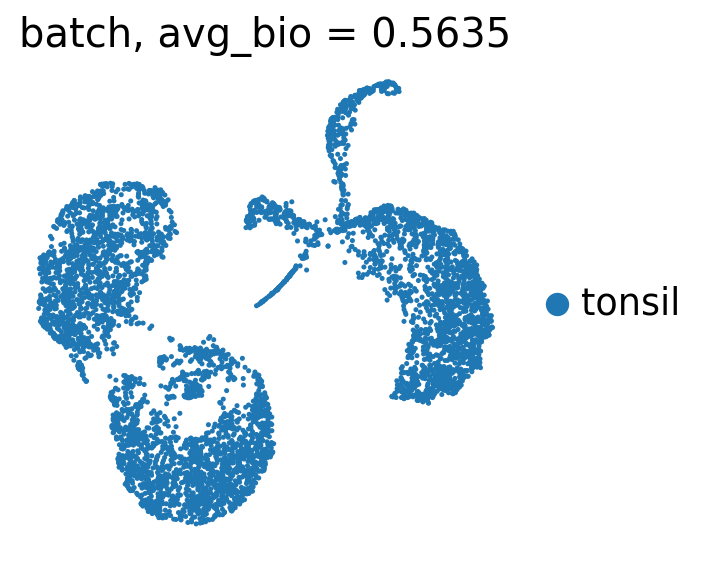

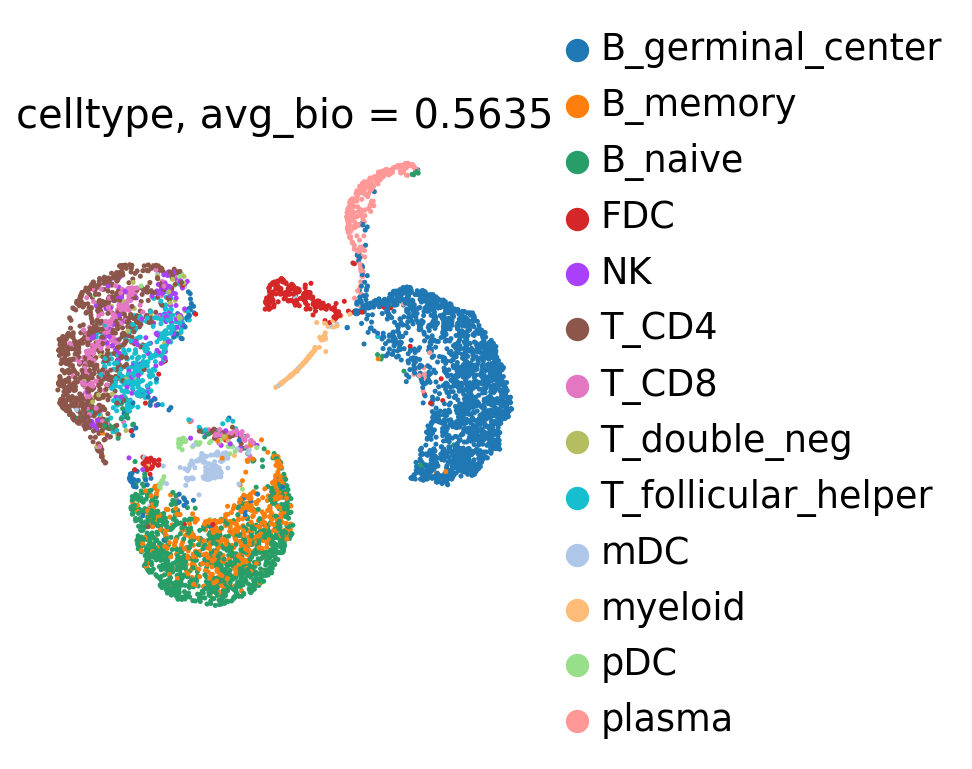

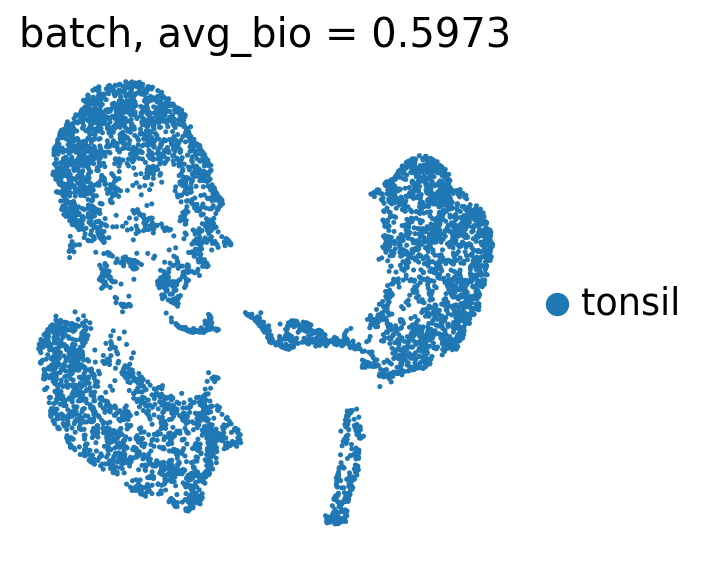

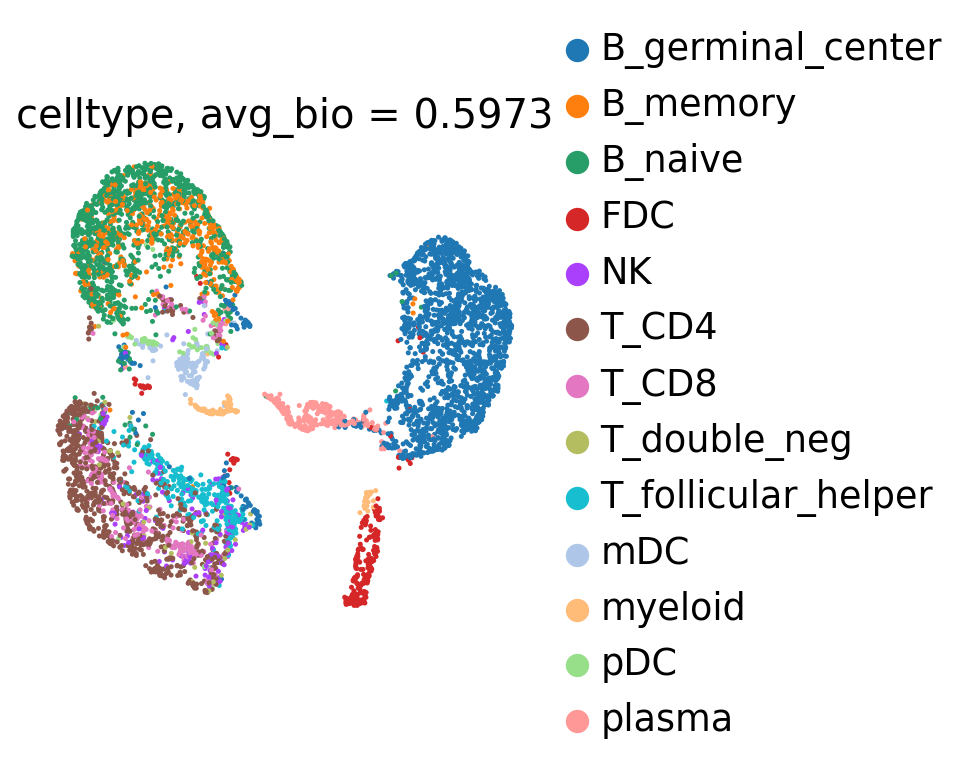

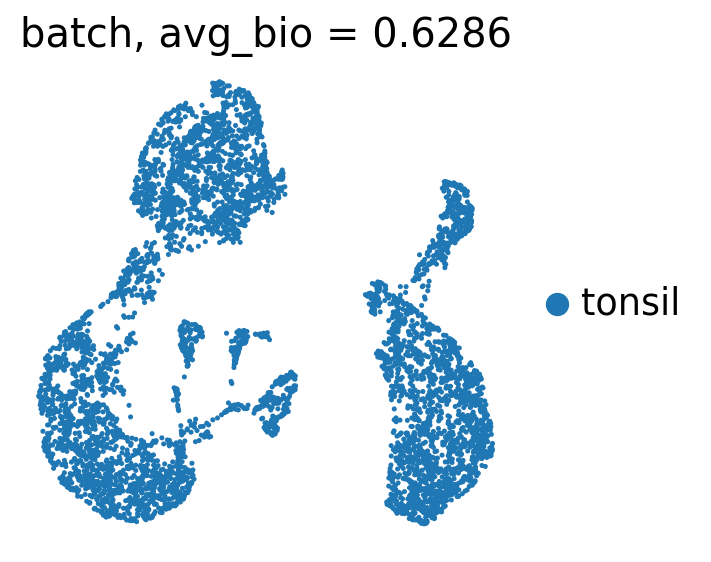

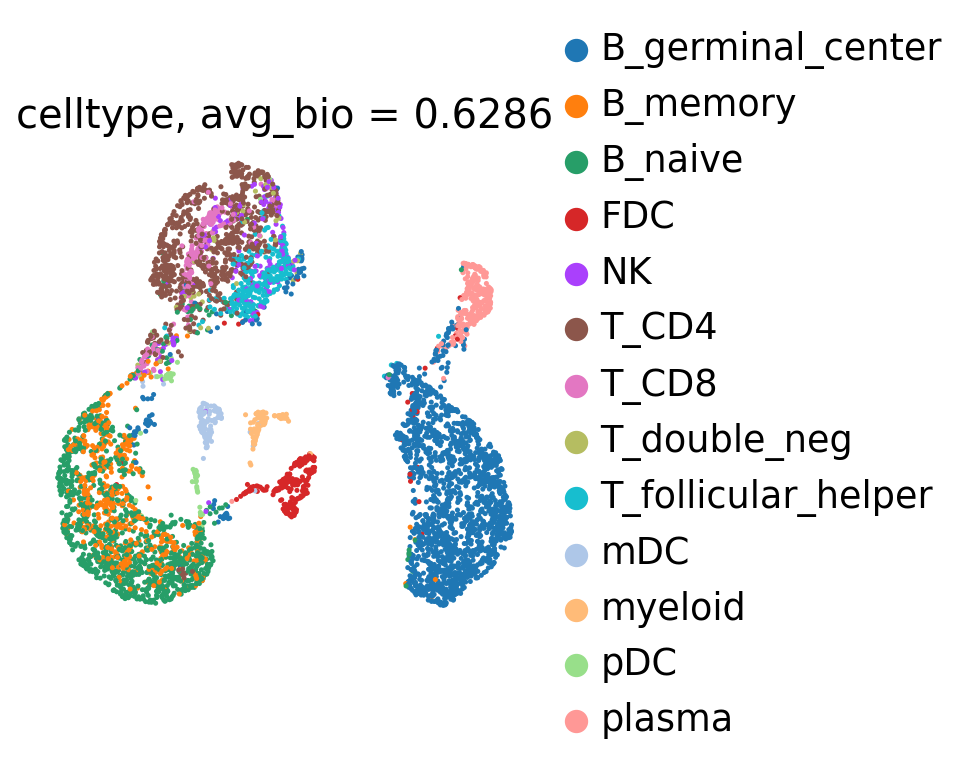

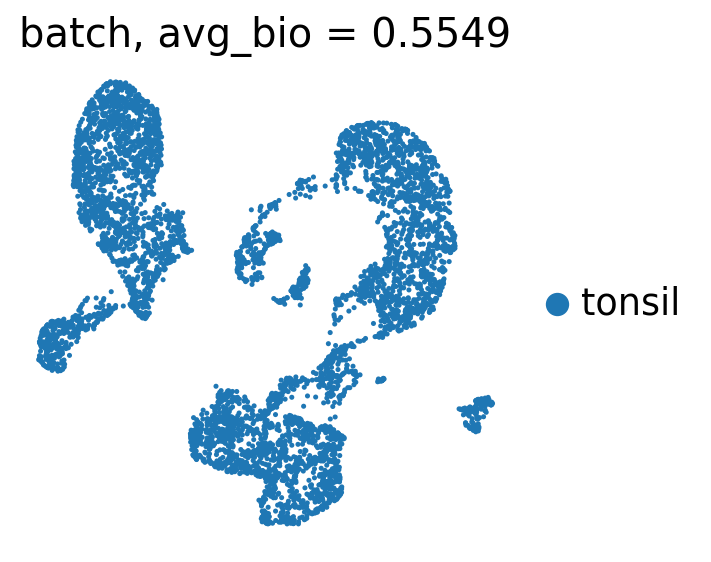

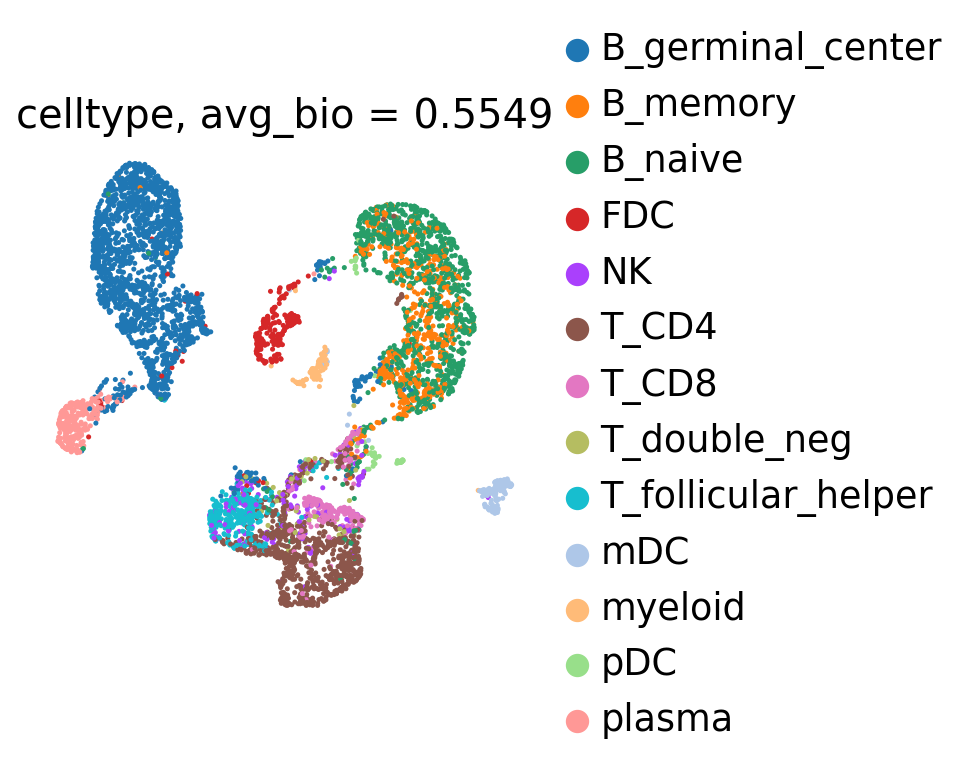

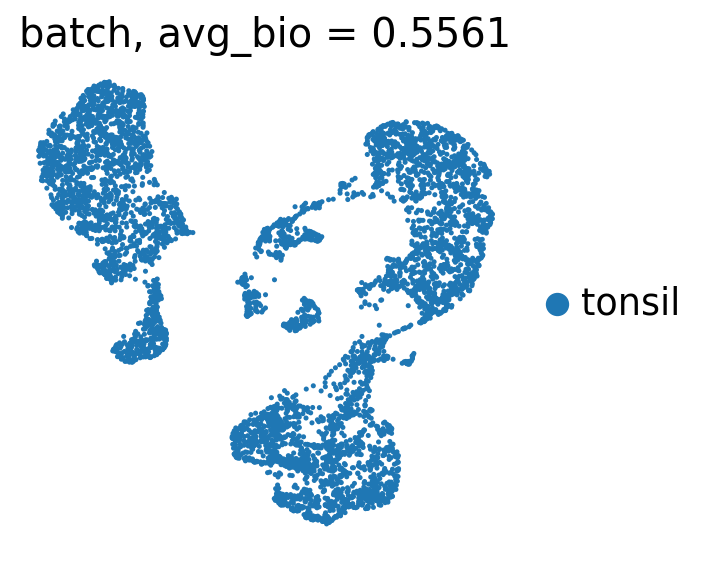

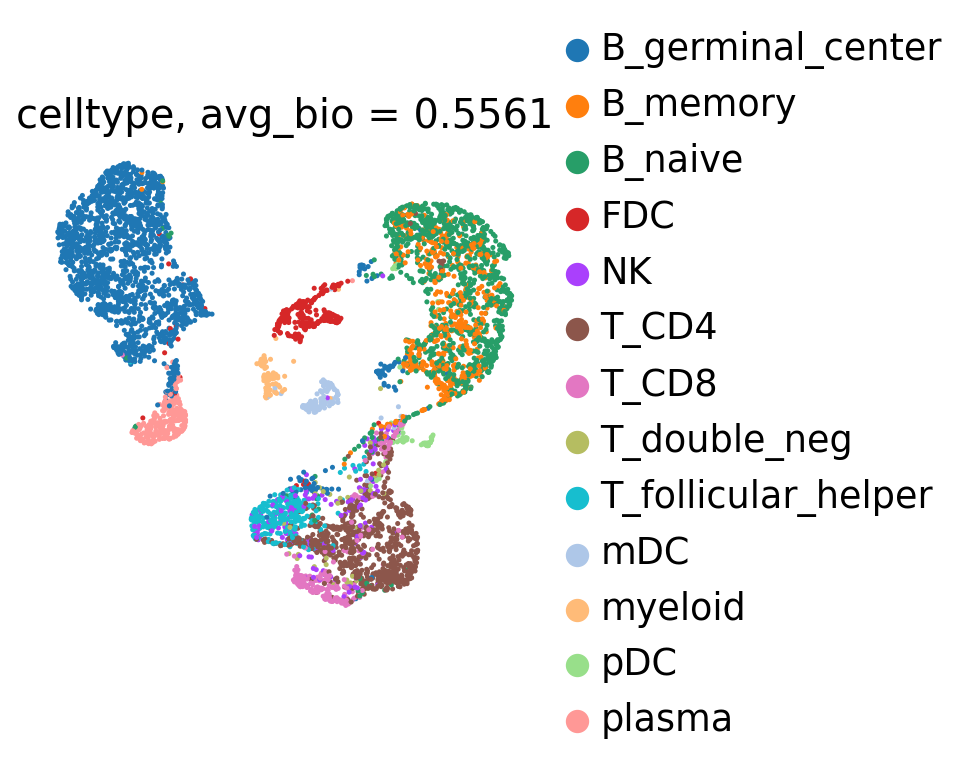

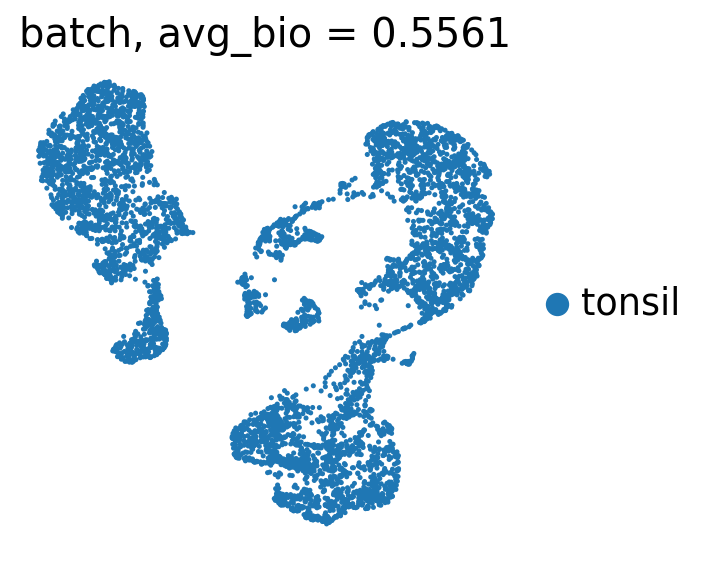

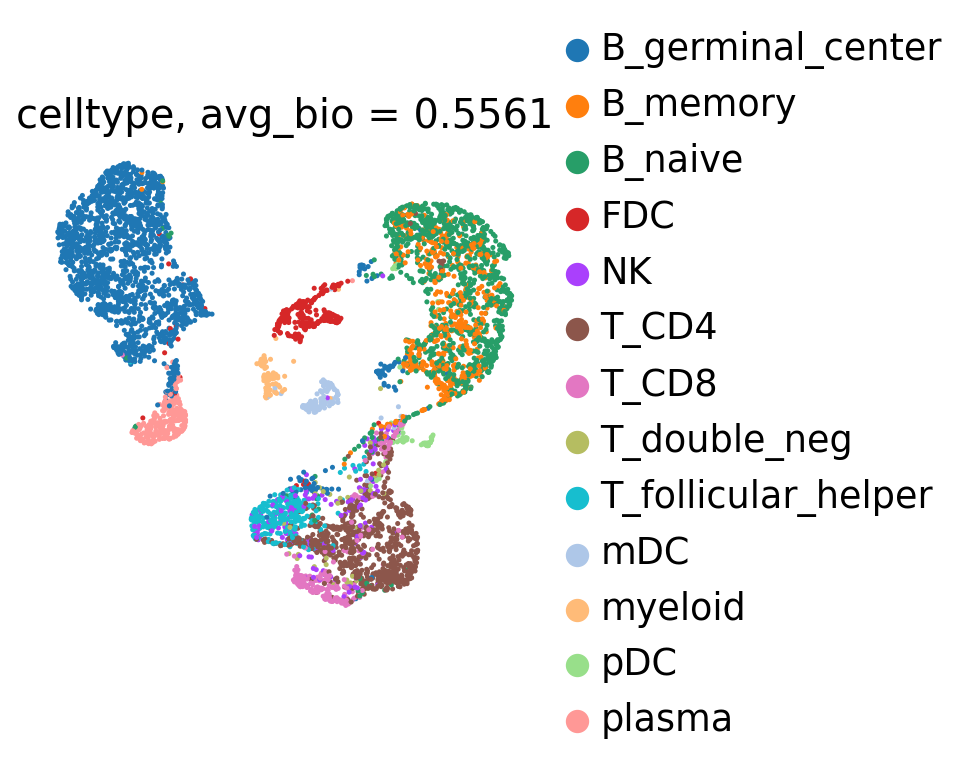

In [22]:
best_val_loss = float("inf")
best_avg_bio = 0.0
best_model = None
define_wandb_metrcis()

for epoch in range(1, config.epochs + 1):
    epoch_start_time = time.time()
    train_data_pt, valid_data_pt = prepare_data(sort_seq_batch=per_seq_batch_sample)
    train_loader = prepare_dataloader(
        train_data_pt,
        batch_size=config.batch_size,
        shuffle=False,
        intra_domain_shuffle=True,
        drop_last=False,
    )
    valid_loader = prepare_dataloader(
        valid_data_pt,
        batch_size=config.batch_size,
        shuffle=False,
        intra_domain_shuffle=False,
        drop_last=False,
    )

    if config.do_train:
        train(
            model,
            loader=train_loader,
        )
    val_loss, val_mre = evaluate(
        model,
        loader=valid_loader,
    )
    elapsed = time.time() - epoch_start_time
    logger.info("-" * 89)
    logger.info(
        f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
        f"valid loss/mse {val_loss:5.4f} | mre {val_mre:5.4f}"
    )
    logger.info("-" * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        best_model_epoch = epoch
        logger.info(f"Best model with score {best_val_loss:5.4f}")

    if epoch % config.save_eval_interval == 0 or epoch == config.epochs:
        logger.info(f"Saving model to {save_dir}")
        torch.save(best_model.state_dict(), save_dir / f"model_e{best_model_epoch}.pt")

        # eval on testdata
        results = eval_testdata(
            best_model,
            adata_t=adata_sorted if per_seq_batch_sample else adata,
            include_types=["cls"],
        )
        results["batch_umap"].savefig(
            save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png", dpi=300
        )

        results["celltype_umap"].savefig(
            save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png", dpi=300
        )
        metrics_to_log = {"test/" + k: v for k, v in results.items()}
        metrics_to_log["test/batch_umap"] = wandb.Image(
            str(save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png"),
            caption=f"celltype avg_bio epoch {best_model_epoch}",
        )

        metrics_to_log["test/celltype_umap"] = wandb.Image(
            str(save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png"),
            caption=f"celltype avg_bio epoch {best_model_epoch}",
        )
        metrics_to_log["test/best_model_epoch"] = best_model_epoch
        wandb.log(metrics_to_log)
        wandb.log({"avg_bio": results.get("avg_bio", 0.0)})

    scheduler.step()



In [23]:
# save the best model
torch.save(best_model.state_dict(), save_dir / "best_model.pt")


## Gene embeddings

In [26]:
save_dir = '/ix3/djishnu/alw399/SpaceOracle/notebooks/benchmark/scGPT-tonsil/save/dev_scGPT_tonsil-Jun13-12-47'

In [32]:
pretrain_dir = '/ix3/djishnu/alw399/SpaceOracle/notebooks/benchmark/scGPT-human'

In [34]:
# Specify model path; here we load the pre-trained scGPT blood model
model_dir = Path(save_dir)
model_config_file = Path(pretrain_dir) / "args.json"
model_file = model_dir / "best_model.pt"
vocab_file = Path(pretrain_dir) / "vocab.json"

vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

# Retrieve model parameters from config files
with open(model_config_file, "r") as f:
    model_configs = json.load(f)
print(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)
embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

gene2idx = vocab.get_stoi()

Resume model from /ix3/djishnu/alw399/SpaceOracle/notebooks/benchmark/scGPT-tonsil/save/dev_scGPT_tonsil-Jun13-12-47/best_model.pt, the model args will override the config /ix3/djishnu/alw399/SpaceOracle/notebooks/benchmark/scGPT-human/args.json.


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
)

try:
    model.load_state_dict(torch.load(model_file))
    print(f"Loading all model params from {model_file}")
except:
    # only load params that are in the model and match the size
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        print(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)

Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
Loading params encoder.enc_norm.weight with shape torch.Size([512])
Loading params encoder.enc_norm.bias with shape torch.Size([512])
Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
Loading params value_encoder.linear1.bias with shape torch.Size([512])
Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
Loading params value_encoder.linear2.bias with shape torch.Size([512])
Loading params value_encoder.norm.weight with shape torch.Size([512])
Loading params value_encoder.norm.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.linear1.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.linear1.bias with 

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, el

In [36]:
# Retrieve the data-independent gene embeddings from scGPT
gene_ids = np.array([id for id in gene2idx.values()])
gene_embeddings = model.encoder(torch.tensor(gene_ids, dtype=torch.long).to(device))
gene_embeddings = gene_embeddings.detach().cpu().numpy()

In [37]:
# Filter on the intersection between the Immune Human HVGs found in step 1.2 and scGPT's 30+K foundation model vocab
gene_embeddings = {gene: gene_embeddings[i] for i, gene in enumerate(gene2idx.keys()) if gene in adata.var.index.tolist()}
print('Retrieved gene embeddings for {} genes.'.format(len(gene_embeddings)))

Retrieved gene embeddings for 3299 genes.


In [38]:
from scgpt.tasks import GeneEmbedding
# Construct gene embedding network
embed = GeneEmbedding(gene_embeddings)

100%|██████████| 3299/3299 [00:00<00:00, 2575285.48it/s]


In [39]:
# Perform Louvain clustering with desired resolution; here we specify resolution=40
gdata = embed.get_adata(resolution=40)
# Retrieve the gene clusters
metagenes = embed.get_metagenes(gdata)

In [40]:
# Obtain the set of gene programs from clusters with #genes >= 5
mgs = dict()
for mg, genes in metagenes.items():
    if len(genes) > 4:
        mgs[mg] = genes

In [41]:
mgs

{'299': ['PTPRT', 'NTNG1', 'ADARB2', 'SORCS1', 'POU6F2'],
 '75': ['SEMA6A',
  'PARD3B',
  'ZNF521',
  'FREM1',
  'FBXL7',
  'ERBB4',
  'PREX2',
  'RELN',
  'SOX2-OT'],
 '196': ['PTPRS', 'PPM1E', 'AFF2', 'SOX5', 'TMEM108', 'TOX', 'SOBP'],
 '300': ['PTPRQ', 'OTOGL', 'NPY1R', 'DACH1', 'SEMA3A'],
 '55': ['PTPRG',
  'PRKG1',
  'GRIP1',
  'PTPRM',
  'XKR4',
  'RBMS3',
  'RORA',
  'ZNF385D',
  'TENM3',
  'UTRN'],
 '15': ['PTMA',
  'HSPA1B',
  'HSPE1',
  'HMGN2',
  'HMGB1',
  'CENPF',
  'HMGB2',
  'HSP90AB1',
  'NCL',
  'HSP90AA1',
  'TUBB',
  'RRM2',
  'TOP2A',
  'HSPA1A'],
 '172': ['ITGA6', 'COBLL1', 'IQGAP2', 'ARHGAP18', 'TBL1X', 'ATP10A', 'SNTB1'],
 '27': ['MERTK',
  'CD163',
  'DAB2',
  'MSR1',
  'SLCO2B1',
  'C1QC',
  'F13A1',
  'MRC1',
  'CTSC',
  'CSF1R',
  'STAB1',
  'C1QB'],
 '336': ['KCNQ1OT1', 'KCNQ1', 'AZIN2', 'ARHGAP22', 'LDLRAD3'],
 '62': ['TRAT1',
  'SLAMF1',
  'GPR174',
  'GPR171',
  'CD40LG',
  'ICOS',
  'CD28',
  'CD96',
  'IL7R',
  'CD2'],
 '224': ['PRSS53', 'OR2L3', 'DNAH8

In [42]:
import json

with open('/ix/djishnu/shared/djishnu_kor11/scGPT_outputs/tonsil_mgs.json', 'w') as f:
    json.dump(mgs, f, indent=2)  

In [46]:
embed_adata = scg.tasks.embed_data(
    adata,
    save_dir,
    gene_col='index',
    batch_size=32,
    # return_new_adata=True,
)
embed_adata

scGPT - INFO - match 3299/3299 genes in vocabulary of size 60697.


/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Embedding cells: 100%|██████████| 181/181 [00:04<00:00, 40.99it/s]
/ix3/djishnu/alw399/envs/scGPT/lib/python3.10/site-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


AnnData object with n_obs × n_vars = 5778 × 3299
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes', 'batch', 'celltype', 'str_batch', 'batch_id'
    var: 'gene_name', 'id_in_vocab', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'index'
    uns: 'cell_thresholds', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl', 'hvg'
    obsm: 'spatial', 'spatial_unscaled', 'bin_edges', 'X_scGPT'
    layers: 'imputed_count', 'normalized_count', 'X_normed', 'X_binned'

In [47]:
import pandas as pd 
gpt_embeds = pd.DataFrame(embed_adata.obsm['X_scGPT'], index=embed_adata.obs.index)
gpt_embeds

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
NAME,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGCGCCTTG-1,-0.003494,-0.006743,-0.103089,-0.015198,0.029973,-0.024286,-0.005571,0.003750,-0.114540,0.014714,...,0.013593,0.020680,0.038465,-0.001271,-0.034672,-0.015202,0.090666,-0.060438,-0.082228,-0.078074
AAACCCAAGTGGACGT-1,0.010101,-0.003245,-0.135264,-0.015993,0.008276,-0.076365,-0.049154,0.008726,-0.033074,0.015423,...,0.013480,-0.045929,0.012755,0.062150,-0.074618,-0.051776,0.041987,-0.045612,-0.030907,-0.030631
AAACCCACAGAAGTGC-1,0.004700,0.013337,-0.104032,-0.009418,0.006333,-0.048990,-0.034330,0.017972,-0.036930,-0.011726,...,-0.017284,-0.008427,0.037299,0.046747,-0.061259,-0.024161,0.067507,-0.051945,-0.038690,-0.008384
AAACCCAGTCATTGCA-1,-0.001007,-0.006893,-0.114141,-0.016441,0.051123,-0.056628,0.002363,0.009627,-0.093479,0.012282,...,0.008622,-0.016692,0.037638,0.012369,-0.065162,-0.018088,0.064385,-0.063548,-0.072554,-0.068194
AAACCCATCATCGCAA-1,0.001404,0.001324,-0.109250,-0.012359,0.064381,-0.041787,0.012484,-0.019308,-0.079210,0.003730,...,-0.000946,-0.014631,0.031088,0.023518,-0.059036,0.004681,0.070573,-0.036428,-0.059939,-0.053162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCAGGGACTA-1,-0.008081,0.016104,-0.100528,-0.012322,-0.000091,-0.056131,-0.047794,0.004819,-0.047758,0.006025,...,-0.008752,-0.001034,0.023212,0.035541,-0.063560,-0.019724,0.068384,-0.045388,-0.040711,-0.015661
TTTGTTGCATTGTAGC-1,0.009213,-0.009043,-0.143006,-0.010538,0.028408,-0.084583,-0.045866,0.009694,-0.048528,0.022352,...,0.013744,-0.056847,0.017605,0.067862,-0.073382,-0.045807,0.044794,-0.049628,-0.042560,-0.047943
TTTGTTGGTACCACGC-1,-0.005432,0.012531,-0.110020,-0.025366,0.009838,-0.058218,-0.030209,-0.004235,-0.033872,-0.003826,...,-0.008660,-0.003109,0.018340,0.050234,-0.061219,-0.021346,0.064114,-0.042234,-0.041053,-0.021847


In [48]:
gpt_embeds.to_parquet('/ix/djishnu/shared/djishnu_kor11/scGPT_outputs/tonsil_embeddings.parquet')